In [2]:
import os
import math
import json
import datetime
import numpy as np
import pandas as pd

from tifffile import tifffile

from skimage import morphology, filters, transform, measure
from skimage.feature import peak_local_max

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib import cm

from scipy import stats, optimize
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.stats import levene
from scipy.ndimage import center_of_mass

def plane(X, a, b, c):
    '''equation for a plane for approximating background subtractions in cropped microscope images'''
    return(a*X[0] + b * X[1] + c)


class simpleStimData:
    '''
    class for interpreting data saved on the microscope during live-cell tracking and computer-
    generated opto experiments. Contains information about the state of the microscope, the images
    themselves, and has methods for background subtraction and some basic processing
    '''
    def __init__(self, folderpath):
        self.folderpath = folderpath
        self.xpath_rot = []
        self.ypath_rot = []
        self.assay_type = ''
        self.get_image_paths()
        self.get_stage_data()
        self.transform_mats = self.get_transformation_matrices()
        self.get_image_stacks()
        self.background_subtraction()
        
    def get_image_paths(self):
        
        # collect image paths within the folder
        try:
            im_path_list = np.sort([self.folderpath + '/' + i for i in np.sort(os.listdir(self.folderpath))])
        except:
            im_path_list = np.sort([self.folderpath + '/' + i.decode('ascii') for i in np.sort(os.listdir(self.folderpath))])

        self.ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        self.ch1_path_list = np.sort([i for i in im_path_list if 'channel001' in i])
        self.ch2_path_list = np.sort([i for i in im_path_list if 'channel002' in i])
        self.ch3_path_list = np.sort([i for i in im_path_list if 'channel003' in i])
        self.ch4_path_list = np.sort([i for i in im_path_list if 'channel004' in i])
        self.ch5_path_list = np.sort([i for i in im_path_list if 'channel005' in i])
        self.ch6_path_list = np.sort([i for i in im_path_list if 'channel006' in i])
        
    def get_stage_data(self):
        
        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:

                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)

        # convert to numpy arrays to make translation and rotation a little easier
        self.x_stage_sequence = np.array(x_stage_sequence)
        self.y_stage_sequence = np.array(y_stage_sequence)

        # center paths on the moment of stimulation
        x_translated = self.x_stage_sequence - self.x_stage_sequence[10] 
        y_translated = self.y_stage_sequence - self.y_stage_sequence[10]

        # calculate the initial direction of the cell in the first ten frames
        self.theta = np.arctan2(-np.average(np.diff(y_translated[:10])), np.average(np.diff(x_translated[:10])))

        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - self.theta  + math.pi/2

        self.x_rotated = rho * np.cos(phi)
        self.y_rotated = rho * np.sin(phi)
        self.centering_x = self.x_stage_sequence[10]
        self.centering_y = self.y_stage_sequence[10]
        

    def get_transformation_matrices(self):
        
        temptif = tifffile.TiffFile(self.ch0_path_list[0])
        centering_matrix = np.array([[1, 0, -200],[0, 1, -200],[0, 0, 1]])
        affine_matrix = np.vstack([np.array([float(i) for i in temptif.shaped_metadata[0]['PixelSizeAffine'].split(';')]).reshape(2, 3), np.array([0, 0, 1])])
        rotation_matrix = np.array([[np.cos(self.theta), -np.sin(self.theta), 0], [np.sin(self.theta), np.cos(self.theta), 0], [0, 0, 1]])
        transformation_matrix = np.matmul(affine_matrix, centering_matrix)
        transformation_matrix = np.matmul(rotation_matrix, transformation_matrix)


        transformation_matrices = []
        for t in range(len(self.x_stage_sequence)):

            xt = (self.x_stage_sequence[t] - self.centering_x)
            yt = (self.y_stage_sequence[t] - self.centering_y)

            xr, yr, placeholder = np.matmul(rotation_matrix, np.array([xt, yt, 0]))
            translation_matrix = np.array([[1, 0, xr],[0, 1, yr],[0, 0, 1]])

            tm = np.matmul(translation_matrix, transformation_matrix)

            transformation_matrices.append(tm.copy())

        return(transformation_matrices)

        
    def get_image_stacks(self):
        
        # make some containers for the pixel intensity information
        self.ch0_stack = np.zeros((len(self.ch0_path_list), 400, 400))
        self.ch1_stack = np.zeros((len(self.ch1_path_list), 400, 400))
        self.ch2_stack = np.zeros((len(self.ch2_path_list), 400, 400))
        self.ch3_stack = np.zeros((len(self.ch3_path_list), 400, 400))
        self.ch4_stack = np.zeros((len(self.ch4_path_list), 400, 400))
        self.ch5_stack = np.zeros((len(self.ch5_path_list), 400, 400))
        self.ch6_stack = np.zeros((len(self.ch6_path_list), 400, 400))
        
        # and for elapsed time
        self.ch0_times = np.zeros(len(self.ch0_path_list))
        self.ch1_times = np.zeros(len(self.ch1_path_list))
        self.ch2_times = np.zeros(len(self.ch2_path_list))
        self.ch3_times = np.zeros(len(self.ch3_path_list))
        self.ch4_times = np.zeros(len(self.ch4_path_list))
        self.ch5_times = np.zeros(len(self.ch5_path_list))
        self.ch6_times = np.zeros(len(self.ch6_path_list))
        
        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:
                self.ch0_stack[i] = temptif.asarray()
                try:
                    self.ch0_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass

        for i in range(len(self.ch1_path_list)):
            with tifffile.TiffFile(self.ch1_path_list[i]) as temptif:
                self.ch1_stack[i] = temptif.asarray()
                try:
                    self.ch1_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch2_path_list)):
            with tifffile.TiffFile(self.ch2_path_list[i]) as temptif:
                self.ch2_stack[i] = temptif.asarray()
                try:
                    self.ch2_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch3_path_list)):
            with tifffile.TiffFile(self.ch3_path_list[i]) as temptif:
                self.ch3_stack[i] = temptif.asarray()
                try:
                    self.ch3_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch4_path_list)):
            with tifffile.TiffFile(self.ch4_path_list[i]) as temptif:
                self.ch4_stack[i] = temptif.asarray()
                try:
                    self.ch4_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch5_path_list)):
            with tifffile.TiffFile(self.ch5_path_list[i]) as temptif:
                self.ch5_stack[i] = temptif.asarray()
                try:
                    self.ch5_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch6_path_list)):
            with tifffile.TiffFile(self.ch6_path_list[i]) as temptif:
                self.ch6_stack[i] = temptif.asarray()
                try:
                    self.ch6_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
        
        
    def get_transformed_xy_coords(self, timepoint):
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz = np.ones_like(xx)

        coords = np.array([xx.ravel(), yy.ravel(), zz.ravel()])
        y_um, x_um, placeholder = np.matmul(self.transform_mats[timepoint], coords)
        
        return(x_um.reshape(400,400), y_um.reshape(400,400))

    
    def background_subtraction(self):
        # fit a plane to the median of non-cell signal over the course of the experiment
        bgstack_ch0 = []
        bgstack_ch1 = []
        for T in range(len(self.ch0_stack)):
            bg_ch0 = self.ch0_stack[T].copy()
            bg_ch1 = self.ch1_stack[T].copy()
            cell = self.ch3_stack[T] == 1
            cell = morphology.binary_dilation(cell, selem = morphology.disk(10))
            bg_ch0[cell] = np.nan
            bg_ch1[cell] = np.nan
            bgstack_ch0.append(bg_ch0)
            bgstack_ch1.append(bg_ch1)

        measured_bg_ch0 = np.nanmedian(bgstack_ch0, axis = 0)
        measured_bg_ch1 = np.nanmedian(bgstack_ch1, axis = 0)
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz_ch0 = measured_bg_ch0
        zz_ch1 = measured_bg_ch1

        xx = xx[np.isfinite(zz_ch0)]
        yy = yy[np.isfinite(zz_ch0)]
        zz_ch0 = zz_ch0[np.isfinite(zz_ch0)]
        zz_ch1 = zz_ch1[np.isfinite(zz_ch1)]

        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(plane, X, zz_ch0, p0 = [1, 1, 500])
        popt_ch1, pcov = optimize.curve_fit(plane, X, zz_ch1, p0 = [1, 1, 500])
        
        X = np.meshgrid(np.arange(400), np.arange(400))
        self.ch0_estimated_bg = plane(X, popt_ch0[0], popt_ch0[1], popt_ch0[2])
        self.ch1_estimated_bg = plane(X, popt_ch1[0], popt_ch1[1], popt_ch1[2])
    
    def calculate_global_dynamics(self):
        ch0_avg = []
        ch1_avg = []
        
        for T in range(len(self.ch0_stack)):
            try:
                ch0_F = np.average((self.ch0_stack[T] - self.ch0_estimated_bg)[self.ch3_stack[T] > 0])
                ch1_F = np.average((self.ch1_stack[T] - self.ch1_estimated_bg)[self.ch3_stack[T] > 0])
                
            except:
                ch0_F = np.nan
                ch1_F = np.nan
                
            ch0_avg.append(ch0_F)
            ch1_avg.append(ch1_F)
            
        self.ch0_dynamics = np.array(ch0_avg)
        self.ch1_dynamics = np.array(ch1_avg)
        
    def calculate_frontbackSignals(self):
        ch0_frontback = []
        ch1_frontback = []

        for T in range(len(self.ch0_stack)):

            try:
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                xx -= 200
                yy -= 200

                regions = measure.regionprops((self.ch3_stack[T] > 0).astype(int), intensity_image = self.ch1_stack[T] - self.ch1_estimated_bg)
                yc, xc = regions[0].centroid
                yw, xw = regions[0].weighted_centroid
                direction = np.arctan2(yw - yc, xw - xc)

                dist = np.hypot(xx, yy)
                angle = np.arctan2(yy, xx)
                dmap = dist * np.cos(angle - direction)
                dmap[self.ch3_stack[T] == 0] = np.nan

                frontloc = np.unravel_index(np.nanargmax(dmap), dmap.shape)
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                dmap2 = np.hypot(yy - frontloc[0], xx - frontloc[1])
                x, y = dmap2[self.ch3_stack[T] > 0], self.ch0_stack[T][self.ch3_stack[T] > 0] - self.ch0_estimated_bg[self.ch3_stack[T] > 0]
                bs, be, bn = stats.binned_statistic(x, y, statistic = 'mean', bins = np.arange(0, 101))

                y2 = self.ch1_stack[T][self.ch3_stack[T] > 0] - self.ch1_estimated_bg[self.ch3_stack[T] > 0]
                bs2, be, bn = stats.binned_statistic(x, y2, statistic = 'mean', bins = np.arange(0, 101))

            except:
                bs = np.zeros(100) + np.nan
                bs2 = np.zeros(100) + np.nan

            ch0_frontback.append(bs)
            ch1_frontback.append(bs2)
            
        self.ch0_frontback = ch0_frontback
        self.ch1_frontback = ch1_frontback
        
    def get_angular_representation(self):
        
        self.ch0_ring = []
        self.ch1_ring = []
        self.ch2_ring = []
        
        self.ringstack = []

        pixch0 = []
        pixch1 = []
        for T in range(10):
            if np.sum(self.ch3_stack[T]) > 0:
                vals = self.ch0_stack[T][self.ch3_stack[T] > 0] - self.ch0_estimated_bg[self.ch3_stack[T] > 0]
                pixch0 = np.hstack([pixch0, vals])
                vals = self.ch1_stack[T][self.ch3_stack[T] > 0] - self.ch1_estimated_bg[self.ch3_stack[T] > 0]
                pixch1 = np.hstack([pixch1, vals])
        ch0_basal = np.average(pixch0)
        ch1_basal = np.average(pixch1)


        for T in range(len(self.ch3_stack)):
            try:
                outer = self.ch3_stack[T] > 0

                inner = morphology.binary_erosion(outer, selem = morphology.disk(15))
                ring = morphology.binary_erosion(outer, selem = morphology.disk(1)) & ~inner

                self.ringstack.append(ring)

                yc, xc = center_of_mass(self.ch3_stack[T])

                yy, xx = np.where(ring)
                A = np.arctan2(-(yy - yc), (xx - xc)) + self.theta
                A = np.arctan2(-np.sin(A), np.cos(A))

                F = self.ch0_stack[T][ring] - self.ch0_estimated_bg[ring]
                F /= ch0_basal
                bs, be, bn = stats.binned_statistic(A, F, statistic = 'mean', bins = np.linspace(-math.pi, math.pi, 101))
                self.ch0_ring.append(bs)

                F = self.ch1_stack[T][ring] - self.ch1_estimated_bg[ring]
                F /= ch1_basal
                bs, be, bn = stats.binned_statistic(A, F, statistic = 'mean', bins = np.linspace(-math.pi, math.pi, 101))
                self.ch1_ring.append(bs)

                bs, be, bn = stats.binned_statistic(A, self.ch2_stack[T][ring], statistic = 'mean', bins = np.linspace(-math.pi, math.pi, 101))
                self.ch2_ring.append(bs)


            except:
                self.ch0_ring.append(np.zeros(100) + np.nan)
                self.ch1_ring.append(np.zeros(100) + np.nan)
                self.ch2_ring.append(np.zeros(100) + np.nan)
            

    

def get_tform_mat(input_bin, theta):
    '''
    Given a binary image representing a single cell and an angle,
    generate the transformation matrix that allows for rotation about
    the center of mass of the binary input by theta
    '''

    input_lbl = measure.label(input_bin)
    region = measure.regionprops(input_lbl)[0]
    y_c, x_c = region.centroid

    c = np.cos(theta)
    s = np.sin(theta)
    t_y = -y_c
    t_x = -x_c

    # translation followed by rotation
    tsl_mat = np.array([[1, 0, 0], [0, 1, 0], [t_x, t_y, 1]])
    rot_mat = np.array([[c, -s, 0],[s, c, 0],[0, 0, 1]])

    tfm_mat = np.matmul(tsl_mat, rot_mat)

    return(tfm_mat)

def get_lateral_points(input_bin, theta):
    '''
    Given a binary image representing the location of a single cell
    and the corresponding fluorescence image, calculate a polarity vector
    based on the fluorescence image and locate the lateral sides of the cell
    relative to the polarity vector
    '''

    tfm_mat = get_tform_mat(input_bin, theta)

    # collect coordinates and transform
    all_ys, all_xs = np.where(input_bin)
    all_zs = np.ones_like(all_ys)

    coords_initial = np.array([all_xs, all_ys, all_zs]).T
    coords_tformed = np.matmul(coords_initial, tfm_mat)

    x, y, z = coords_tformed.T

    # look for furthest lateral sides in transformed coordinates
    ymax = np.max(y[(x < 1) & (x > -1)])
    ymin = np.min(y[(x < 1) & (x > -1)])

    # apply inverse transformation to lateral coordinates
    x_R, y_R, placeholder = np.matmul(np.array([0, ymin, 1]), np.linalg.inv(tfm_mat))
    x_L, y_L, placeholder = np.matmul(np.array([0, ymax, 1]), np.linalg.inv(tfm_mat))

    return([x_R, y_R, x_L, y_L])

In [3]:
CONDITION = '_lateral90_'

undiffpaths = []

path = 'data/fig03data/twospot/'
for i in os.listdir(path):
    if CONDITION in i:
        undiffpaths.append(path + i)
        
print(len(undiffpaths))

path = 'data/simpleStimData/'
diffpaths = [path + i for i in os.listdir(path) if ('_lateral90_' in i)|('_0Rad_' in i)]
print(len(diffpaths))

41
46


In [4]:
all_L0 = []
all_L1 = []
all_R0 = []
all_R1 = []

for i in diffpaths:

    print(i)
    a = simpleStimData(i)
    a.calculate_global_dynamics()
    ch0_norm = a.ch0_dynamics/np.average(a.ch0_dynamics[:10])
    ch1_norm = a.ch1_dynamics/np.average(a.ch1_dynamics[:10])

    if (np.average(ch0_norm) > 1.) and (np.average(ch1_norm) > 1.):

        L0 = []
        L1 = []
        R0 = []
        R1 = []
        
        for T in range(60):
            
            if np.sum(a.ch3_stack[T]) > 0:
                yy, xx = np.where(a.ch3_stack[T])
                L_xx = xx[xx < 200]
                L_yy = yy[xx < 200]
                R_xx = xx[xx > 200]
                R_yy = yy[xx > 200]
                
                L0.append(np.average(a.ch0_stack[T][L_yy, L_xx] - a.ch0_estimated_bg[L_yy, L_xx]))
                L1.append(np.average(a.ch1_stack[T][L_yy, L_xx] - a.ch1_estimated_bg[L_yy, L_xx]))
                R0.append(np.average(a.ch0_stack[T][R_yy, R_xx] - a.ch0_estimated_bg[R_yy, R_xx]))
                R1.append(np.average(a.ch1_stack[T][R_yy, R_xx] - a.ch0_estimated_bg[R_yy, R_xx]))
            else:
                L0.append(np.nan)
                L1.append(np.nan)
                R0.append(np.nan)
                R1.append(np.nan)
                
        L0 = np.array(L0)
        L1 = np.array(L1)
        R0 = np.array(R0)
        R1 = np.array(R1)

        L0 /= np.average(L0[:10])
        L1 /= np.average(L1[:10])
        R0 /= np.average(R0[:10])
        R1 /= np.average(R1[:10])

        
        all_L0.append(L0)
        all_L1.append(L1)
        all_R0.append(R0)
        all_R1.append(R1)

all_L0 = np.array(all_L0)
all_L1 = np.array(all_L1)
all_R0 = np.array(all_R0)
all_R1 = np.array(all_R1)

all_L0_diff = all_L0
all_L1_diff = all_L1
all_R0_diff = all_R0
all_R1_diff = all_R1


/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_002


/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


/home/jason/Data/simpleStimData/211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_003
/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_lateral90_50000_Intensity_000
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_003
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_011
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_009
/home/jason/Data/simpleStimData/211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_013
/home/jason/Data/simpleStimData/220228_KWC_35-52-97_simpleStimScreen_well2_lateral90_50000_Intensity_000


/home/jason/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/jason/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/jason/Data/simpleStimData/211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_007
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_004
/home/jason/Data/simpleStimData/220704_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_001
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_008
/home/jason/Data/simpleStimData/220628_KWC_35-52-97_mcPak_VariousFrontStimulations_lateral90_50000_Intensity_001
/home/jason/Data/simpleStimData/211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_016
/home/jason/Data/simpleStimData/220307_KWC_35-52-97_simpleStimScreen_lateral90_50000_Intensity_002
/home/jason/Data/simpleStimData/211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_005
/home/jason/Data/simpleStimData/211121_KWC_35-52-97mcPAK_twoSpot_angleTest_0Rad_004
/home/jason/Data/simpleStimData/220228_KWC_35-52-97_simpleStimScreen_lateral90_50000_Intensity_000
/home/jason/Da

In [5]:
all_L0 = []
all_L1 = []
all_R0 = []
all_R1 = []
analyzed_undiff_paths = []

for i in undiffpaths:

    print(i)
    a = simpleStimData(i)
    a.calculate_global_dynamics()
    ch0_norm = a.ch0_dynamics/np.average(a.ch0_dynamics[:10])
    ch1_norm = a.ch1_dynamics/np.average(a.ch1_dynamics[:10])

    if (np.average(ch0_norm) > 1.) and (np.average(ch1_norm) > 1.):

        L0 = []
        L1 = []
        R0 = []
        R1 = []
        
        for T in range(60):
            
            if np.sum(a.ch3_stack[T]) > 0:
                yy, xx = np.where(a.ch3_stack[9])
                L_xx = xx[xx < 200]
                L_yy = yy[xx < 200]
                R_xx = xx[xx > 200]
                R_yy = yy[xx > 200]
                
                L0.append(np.average(a.ch0_stack[T][L_yy, L_xx] - a.ch0_estimated_bg[L_yy, L_xx]))
                L1.append(np.average(a.ch1_stack[T][L_yy, L_xx] - a.ch1_estimated_bg[L_yy, L_xx]))
                R0.append(np.average(a.ch0_stack[T][R_yy, R_xx] - a.ch0_estimated_bg[R_yy, R_xx]))
                R1.append(np.average(a.ch1_stack[T][R_yy, R_xx] - a.ch0_estimated_bg[R_yy, R_xx]))
            else:
                L0.append(np.nan)
                L1.append(np.nan)
                R0.append(np.nan)
                R1.append(np.nan)
                
        L0 = np.array(L0)
        L1 = np.array(L1)
        R0 = np.array(R0)
        R1 = np.array(R1)

        L0 /= np.average(L0[:10])
        L1 /= np.average(L1[:10])
        R0 /= np.average(R0[:10])
        R1 /= np.average(R1[:10])


        all_L0.append(L0)
        all_L1.append(L1)
        all_R0.append(R0)
        all_R1.append(R1)
        
all_L0 = np.array(all_L0)
all_L1 = np.array(all_L1)
all_R0 = np.array(all_R0)
all_R1 = np.array(all_R1)

all_L0_undiff = all_L0
all_L1_undiff = all_L1
all_R0_undiff = all_R0
all_R1_undiff = all_R1

data/fig3data/twospot/230425_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_50000_Intensity_011
data/fig3data/twospot/230502_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_20000_Intensity_008
data/fig3data/twospot/230418_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_50000_Intensity_005
data/fig3data/twospot/230502_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_20000_Intensity_012
data/fig3data/twospot/230424_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_50000_Intensity_006
data/fig3data/twospot/230425_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_50000_Intensity_001
data/fig3data/twospot/230424_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_50000_Intensity_004
data/fig3data/twospot/230424_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_50000_Intensity_003
data/fig3data/twospot/230425_KWC_35-52-97_mcPak_undiff_10uMLat_PLL_Assays_lateral90_50000_Intensity_002
data/fig3data/twospot/230418_KWC_35-52-97_mcPak_undiff_10uMLat_P

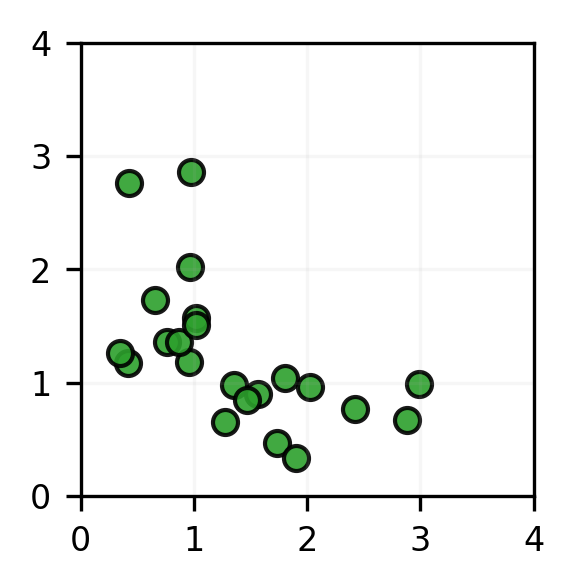

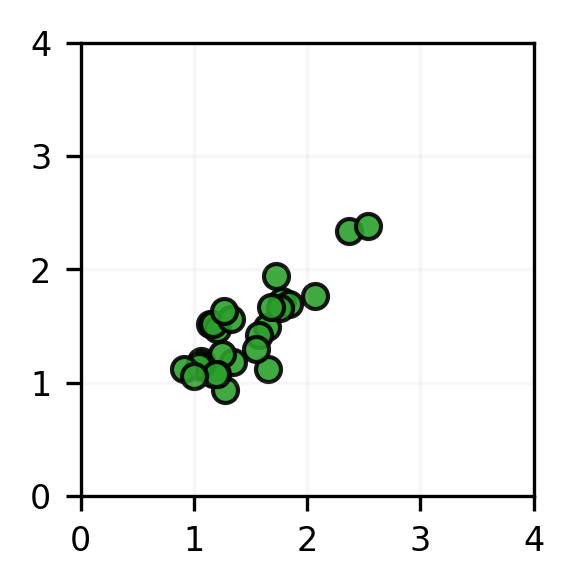

In [6]:
plt.figure(figsize = (2,2), dpi = 300)
plt.subplot(aspect = 'equal')

plt.xticks(range(5), fontsize = 8)
plt.yticks(range(5), fontsize = 8)
plt.axis([0, 4, 0, 4])
plt.grid(alpha = 0.1)
x, y = np.array(all_L0_diff)[:,-1].ravel(), np.array(all_R0_diff)[:,-1].ravel()
plt.scatter(x, y, color = 'C2', ec = 'k', alpha = 0.9)
plt.show()

plt.figure(figsize = (2,2), dpi = 300)
plt.subplot(aspect = 'equal')
plt.xticks(range(5), fontsize = 8)
plt.yticks(range(5), fontsize = 8)
plt.axis([0, 4, 0, 4])
plt.grid(alpha = 0.1)
x, y = np.array(all_L0_undiff)[:,-1].ravel(), np.array(all_R0_undiff)[:,-1].ravel()
plt.scatter(x, y, color = 'C2', ec = 'k', alpha = 0.9)
plt.show()